In [ ]:
%pip install peft accelerate loralib

In [11]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from datasets import Dataset
from torch.utils.data import TensorDataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    integrations,
)


In [34]:
base_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(base_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(base_name)

full_dataset = Dataset.from_text("spam_messages_names.txt")
full_dataset = full_dataset.map(
    lambda example: tokenizer(example["text"]), batched=True
)
data_dict = full_dataset.train_test_split(test_size=0.01, shuffle=True, seed=42)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Using custom data configuration default-c026a0da68931db6
Found cached dataset text (/home/mike/.cache/huggingface/datasets/text/default-c026a0da68931db6/0.0.0)
Loading cached processed dataset at /home/mike/.cache/huggingface/datasets/text/default-c026a0da68931db6/0.0.0/cache-4c558e740f1d48fa.arrow


61057 617
{'text': 'Sōl Astrī: Не похоже', 'input_ids': [55, 134, 240, 80, 49062, 86, 133, 109, 30, 832, 5175], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
430


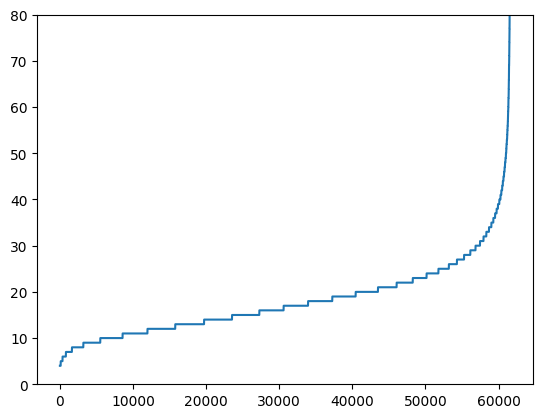

In [35]:
print(len(data_dict["train"]), len(data_dict["test"]))
print(full_dataset[-1])
lengths = np.array(sorted([len(elem["input_ids"]) for elem in full_dataset]))
print(lengths[-1])

plt.plot(lengths)
plt.ylim(0, 80)
plt.show()

In [32]:
for param in model.parameters():
    param.requires_grad = False  # freeze the model - train adapters later
    if param.ndim == 1:
        # cast the small parameters (e.g. layernorm) to fp32 for stability
        param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations


class CastOutputToFloat(nn.Sequential):
    def forward(self, x):
        return super().forward(x).to(torch.float32)


model.lm_head = CastOutputToFloat(model.lm_head)


In [33]:
from peft import LoraConfig, get_peft_model


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable: {100 * trainable_params / all_param:.2f}%"
    )


config = LoraConfig(
    r=16,  # attention heads
    lora_alpha=32,  # alpha scaling
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",  # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)


/home/mike/.local/lib/python3.10/site-packages/peft/tuners/lora.py:240: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 589824 || all params: 125821440 || trainable: 0.47%


In [38]:
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    max_steps=2,
    learning_rate=2e-4,
    logging_steps=1,
    output_dir="outputs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model,
    train_dataset=data_dict["train"],
    eval_dataset=data_dict["test"],
    args=training_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)


PyTorch: setting up devices
max_steps is given, it will override any value given in num_train_epochs


In [39]:
results_before = trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 617
  Batch size = 8
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/78 [00:00<?, ?it/s]

In [63]:
print(results_before)
print(tokenizer.pad_token)
tokenizer._pad_token = tokenizer._eos_token
print(tokenizer.pad_token)
for prompt in ["a ", "Mikhail Budnikov:", "Rodion Khvorostov:", "Veronika Sirotkina:"]:
    print("Results for", prompt)
    for it in range(10):
        tokens = tokenizer(prompt, return_tensors="pt")
        g = model.generate(**tokens, max_new_tokens=20, return_dict_in_generate=True, do_sample=True)
        prediction = g.sequences[0]
        print(tokenizer.decode(prediction))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'eval_loss': 5.105103492736816, 'eval_runtime': 31.114, 'eval_samples_per_second': 19.83, 'eval_steps_per_second': 2.507}
Results for a 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a }\draw[            '#4',            line width=1\pic


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a  (Total): })    public static ObjectsByName()


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a  is a cascade, a tin tail, an inverted taillet,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a ===&amp;gt; {        if(data &amp;gt;=


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a ql_replaceChar;    try    if ((isSimple


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a icon: ico: ico: ico: ico ico: ico 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


a u)}    # $(document).ready(function () {       


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4 │   print("Results for", prompt)                                                            │
│    5 │   for it in range(10):                                                                    │
│    6 │   │   tokens = tokenizer(prompt, return_tensors="pt")                                     │
│ ❱  7 │   │   g = model.generate(**tokens, max_new_tokens=20, return_dict_in_generate=True, do    │
│    8 │   │   prediction = g.sequences[0]                                                         │
│    9 │   │   print(tokenizer.decode(prediction))                                                 │
│   10                                                                                             │
│                                                                                                  │
│ /home/mike/.local/lib/python3.10/site-packages/torch/utils/_contextlib.py:115 in                 │
│ decorate_context                                                                                 │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /home/mike/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1571 in generate │
│                                                                                                  │
│   1568 │   │   │   )                                                                             │
│   1569 │   │   │                                                                                 │
│   1570 │   │   │   # 12. run sample                                                              │
│ ❱ 1571 │   │   │   return self.sample(                                                           │
│   1572 │   │   │   │   input_ids,                                                                │
│   1573 │   │   │   │   logits_processor=logits_processor,                                        │
│   1574 │   │   │   │   logits_warper=logits_warper,                                              │
│                                                                                                  │
│ /home/mike/.local/lib/python3.10/site-packages/transformers/generation/utils.py:2534 in sample   │
│                                                                                                  │
│   2531 │   │   │   model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)  │
│   2532 │   │   │                                                                                 │
│   2533 │   │   │   # forward pass to get next token                                              │
│ ❱ 2534 │   │   │   outputs = self(                                                               │
│   2535 │   │   │   │   **model_inputs,                                                           │
│   2536 │   │   │   │   return_dict=True,                   

In [ ]:
trainer.train()